In [ ]:
!pip install -q opencv-python

In [ ]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
import tensorflow_models as tfm
nlp = tfm.nlp

In [ ]:
cfg = {
    "vocab_size": 100,
    "hidden_size": 32,
    "num_layers": 3,
    "num_attention_heads": 4,
    "intermediate_size": 64,
    "activation": tfm.utils.activations.gelu,
    "dropout_rate": 0.1,
    "attention_dropout_rate": 0.1,
    "max_sequence_length": 16,
    "type_vocab_size": 2,
    "initializer": tf.keras.initializers.TruncatedNormal(stddev=0.02),
}
bert_encoder = nlp.networks.BertEncoder(**cfg)

def build_classifier(bert_encoder):
  return nlp.models.BertClassifier(bert_encoder, num_classes=2)

canonical_classifier_model = build_classifier(bert_encoder)

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
def predict(model):
  batch_size = 3
  np.random.seed(0)
  word_ids = np.random.randint(
      cfg["vocab_size"], size=(batch_size, cfg["max_sequence_length"]))
  mask = np.random.randint(2, size=(batch_size, cfg["max_sequence_length"]))
  type_ids = np.random.randint(
      cfg["type_vocab_size"], size=(batch_size, cfg["max_sequence_length"]))
  print(model([word_ids, mask, type_ids], training=False))

predict(canonical_classifier_model)

tf.Tensor(
[[ 0.00606001 -0.0205723 ]
 [ 0.13570566 -0.20238872]
 [-0.02476082  0.03767319]], shape=(3, 2), dtype=float32)


In [ ]:
default_hidden_cfg = dict(
    num_attention_heads=cfg["num_attention_heads"],
    intermediate_size=cfg["intermediate_size"],
    intermediate_activation=cfg["activation"],
    dropout_rate=cfg["dropout_rate"],
    attention_dropout_rate=cfg["attention_dropout_rate"],
    kernel_initializer=cfg["initializer"],
)

In [ ]:
default_embedding_cfg = dict(
    vocab_size=cfg["vocab_size"],
    type_vocab_size=cfg["type_vocab_size"],
    hidden_size=cfg["hidden_size"],
    initializer=cfg["initializer"],
    dropout_rate=cfg["dropout_rate"],
    max_seq_length=cfg["max_sequence_length"]
)

In [ ]:
default_kwargs = dict(
    hidden_cfg=default_hidden_cfg,
    embedding_cfg=default_embedding_cfg,
    num_hidden_instances=cfg["num_layers"],
    pooled_output_dim=cfg["hidden_size"],
    return_all_layer_outputs=True,
    pooler_layer_initializer=cfg["initializer"],
)

In [ ]:
encoder_scaffold = nlp.networks.EncoderScaffold(**default_kwargs)
classifier_model_from_encoder_scaffold = build_classifier(encoder_scaffold)
classifier_model_from_encoder_scaffold.set_weights(
    canonical_classifier_model.get_weights())
predict(classifier_model_from_encoder_scaffold)

tf.Tensor(
[[ 0.00606001 -0.0205723 ]
 [ 0.13570566 -0.20238872]
 [-0.02476082  0.03767319]], shape=(3, 2), dtype=float32)


In [ ]:
class MyOnDeviceEmbedding(tf.keras.layers.Layer):
  """Performs an embedding lookup suitable for accelerator devices.

  This layer uses either tf.gather or tf.one_hot to translate integer indices to
  float embeddings.

  Args:
    vocab_size: Number of elements in the vocabulary.
    embedding_width: Output size of the embedding layer.
    initializer: The initializer to use for the embedding weights. Defaults to
      "glorot_uniform".
    use_one_hot: Whether to use tf.one_hot over tf.gather for the embedding
      lookup. Defaults to False (that is, using tf.gather). Setting this option
      to True may improve performance, especially on small vocabulary sizes, but
      will generally require more memory.
    scale_factor: Whether to scale the output embeddings. Defaults to None (that
      is, not to scale). Setting this option to a float will let values in
      output embeddings multiplied by scale_factor.
    weight_fallback_dtype: When keras mix precision inferred wrong dtype for
      variables, `weight_fallback_dtype` will be used to define the dtype of
      weights.
  """

  def __init__(self,
               vocab_size,
               embedding_width,
               initializer="glorot_uniform",
               use_one_hot=False,
               scale_factor=None,
               weight_fallback_dtype=tf.float32,
               **kwargs):

    super().__init__(**kwargs)
    self._vocab_size = vocab_size
    self._embedding_width = embedding_width
    self._initializer = initializer
    self._use_one_hot = use_one_hot
    self._scale_factor = scale_factor
    # Backup control of the weight dtype because Keras mix precision sometimes
    # depends on the input to infer the compute dtype, but the inputs of
    # this layer are int type.
    self._weight_fallback_dtype = weight_fallback_dtype

  def get_config(self):
    config = {
        "vocab_size": self._vocab_size,
        "embedding_width": self._embedding_width,
        "initializer": self._initializer,
        "use_one_hot": self._use_one_hot,
        "scale_factor": self._scale_factor,
        "weight_fallback_dtype": self._weight_fallback_dtype,
    }
    base_config = super().get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def build(self, input_shape):
    if (
        self.dtype is not None
        and not tf.dtypes.as_dtype(self.dtype).is_floating
    ):
      # Keras failed to infer the right dtype.
      dtype = self._weight_fallback_dtype
    else:
      dtype = self.dtype
    self.embeddings = self.add_weight(
        "embeddings",
        shape=[self._vocab_size, self._embedding_width],
        initializer=self._initializer,
        dtype=dtype)

    super().build(input_shape)

  def call(self, inputs):
    flat_inputs = tf.reshape(inputs, [-1])
    if self._use_one_hot:
      dtype = self.compute_dtype
      if not tf.dtypes.as_dtype(dtype).is_floating:
        # TensorFlow 1 compatibility. In TF1, self.compute_dtype is int32
        # instead of a floating-point dtype, as the dtype is inferred from the
        # dtype of the inputs
        dtype = self._weight_fallback_dtype
      one_hot_data = tf.one_hot(
          flat_inputs, depth=self._vocab_size, dtype=dtype)
      embeddings = tf.matmul(one_hot_data, self.embeddings)
    else:
      embeddings = tf.gather(self.embeddings, flat_inputs)
    embeddings = tf.reshape(
        embeddings,
        tf.concat([tf.shape(inputs), [self._embedding_width]], axis=0))
    embeddings.set_shape(inputs.shape.as_list() + [self._embedding_width])
    if self._scale_factor:
      embeddings *= self._scale_factor
    return embeddings

  @property
  def vocab_size(self):
    return self._vocab_size

  @property
  def embedding_width(self):
    return self._embedding_width

In [ ]:
cfg['max_sequence_length']

16

In [ ]:
word_ids = tf.keras.layers.Input(
    shape=(cfg['max_sequence_length'],),
    dtype=tf.int32,
    name="input_word_ids")

mask = tf.keras.layers.Input(
    shape=(cfg['max_sequence_length'],),
    dtype=tf.int32, name="input_mask")

embedding_layer = MyOnDeviceEmbedding(
    vocab_size=cfg['vocab_size'],
    embedding_width=cfg['hidden_size'],
    initializer=cfg["initializer"],
    name="word_embeddings")
word_embeddings = embedding_layer(word_ids)
attention_mask = nlp.layers.SelfAttentionMask()([word_embeddings, mask])
new_embedding_network = tf.keras.Model([word_ids, mask],
                                       [word_embeddings, attention_mask])

TypeError: Layer.add_weight() got multiple values for argument 'shape'

In [ ]:
# class MyOnDeviceEmbedding(tf.keras.layers.Layer):
#     def __init__(self, vocab_size, embedding_width, initializer, name=None):
#         super(MyOnDeviceEmbedding, self).__init__(name=name)
#         self.vocab_size = vocab_size
#         self.embedding_width = embedding_width
#         self.initializer = initializer

#     def build(self, input_shape):
#         # Initialize the embedding layer in build method
#         self.embedding_layer = nlp.layers.OnDeviceEmbedding(
#             vocab_size=self.vocab_size,
#             embedding_width=self.embedding_width,
#             initializer=self.initializer
#         )

#     def call(self, inputs):
#         # Apply the embedding layer to the inputs
#         return self.embedding_layer(inputs)

#     def build(self, input_shape):
#         if (
#             self.dtype is not None
#             and not tf.dtypes.as_dtype(self.dtype).is_floating
#         ):
#           # Keras failed to infer the right dtype.
#           dtype = self.weight_fallback_dtype
#         else:
#           dtype = self.dtype
#         self.embeddings = self.add_weight(
#             "embeddings",
#             shape=[self.vocab_size, self.embedding_width],
#             initializer=self.initializer,
#             dtype=dtype)

#         super().build(input_shape)

#     def call(self, inputs):
#         flat_inputs = tf.reshape(inputs, [-1])
#         if self._use_one_hot:
#           dtype = self.compute_dtype
#           if not tf.dtypes.as_dtype(dtype).is_floating:
#             # TensorFlow 1 compatibility. In TF1, self.compute_dtype is int32
#             # instead of a floating-point dtype, as the dtype is inferred from the
#             # dtype of the inputs
#             dtype = self._weight_fallback_dtype
#           one_hot_data = tf.one_hot(
#               flat_inputs, depth=self.vocab_size, dtype=dtype)
#           embeddings = tf.matmul(one_hot_data, self.embeddings)
#         else:
#           embeddings = tf.gather(self.embeddings, flat_inputs)
#         embeddings = tf.reshape(
#             embeddings,
#             tf.concat([tf.shape(inputs), [self.embedding_width]], axis=0))
#         embeddings.set_shape(inputs.shape.as_list() + [self.embedding_width])
#         if self.scale_factor:
#           embeddings *= self.scale_factor
#         return embeddings

# # Example usage
# word_ids = tf.keras.layers.Input(
#     shape=(cfg['max_sequence_length'],), dtype=tf.int32, name="input_word_ids")
# mask = tf.keras.layers.Input(
#     shape=(cfg['max_sequence_length'],), dtype=tf.int32, name="input_mask")

# # Use the custom embedding layer
# embedding_layer = MyOnDeviceEmbedding(
#     vocab_size=cfg['vocab_size'],
#     embedding_width=cfg['hidden_size'],
#     initializer=cfg["initializer"],
#     name="word_embeddings"
# )

In [ ]:
# class CustomAttentionMask(tf.keras.layers.Layer):
#     def call(self, inputs):
#         word_embeddings, mask = inputs
#         mask = tf.cast(tf.expand_dims(mask, axis=-1), dtype=word_embeddings.dtype)
#         return mask * word_embeddings

# # Apply embedding layer
# word_embeddings = embedding_layer(word_ids)

# # Apply the custom attention mask
# attention_mask = CustomAttentionMask()([word_embeddings, mask])

# # Create the Keras model
# new_embedding_network = tf.keras.Model([word_ids, mask], [word_embeddings, attention_mask])

In [ ]:
print(f"Word Embeddings Shape: {word_embeddings.shape}")
print(f"Attention Mask Shape: {attention_mask.shape}")

Word Embeddings Shape: (None, 16, 32)
Attention Mask Shape: (None, 16, 32)


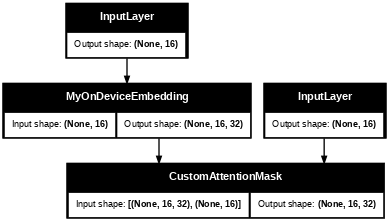

In [ ]:
tf.keras.utils.plot_model(new_embedding_network, show_shapes=True, dpi=48)

In [ ]:
kwargs = dict(default_kwargs)

# Use new embedding network.
kwargs['embedding_cls'] = new_embedding_network
kwargs['embedding_data'] = embedding_layer.embeddings

encoder_with_customized_embedding = nlp.networks.EncoderScaffold(**kwargs)
classifier_model = build_classifier(encoder_with_customized_embedding)
# ... Train the model ...
print(classifier_model.inputs)

# Assert that there are only two inputs.
assert len(classifier_model.inputs) == 2

AttributeError: 'MyOnDeviceEmbedding' object has no attribute 'embeddings'

In [ ]:
attention_mask = nlp.layers.SelfAttentionMask()([mask])

In [ ]:
# Reshape the mask to match the word_embeddings shape
mask_expanded = tf.expand_dims(mask, axis=-1)

# Apply the attention mask
attention_mask = nlp.layers.SelfAttentionMask()([word_embeddings, mask_expanded])


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
class CustomAttentionMask(tf.keras.layers.Layer):
    def call(self, inputs):
        word_embeddings, mask = inputs
        mask = tf.cast(tf.expand_dims(mask, axis=-1), dtype=word_embeddings.dtype)
        return mask * word_embeddings

# Apply the custom attention mask
attention_mask = CustomAttentionMask()([word_embeddings, mask])
